In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle
from calcwf import *

In [2]:
sample_rate = 4096

# Functions

In [9]:
def phase_MA_match(phase_vals, MA_vals, n, fiducials, f_low, approximant='TEOBResumS', data_params=None):

    if data_params is None:
        data_params = fiducials

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'diff_phase':[], 'quad':[]}
    for i in range(n):
            matches[f'h{i+1}'] = []
            matches[f'h{i+1}_phase'] = []
    q_factor_fid = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)
    q_factor_data = (data_params[2]/(1+data_params[2])**2)**(-3/5)

    # Generate fiducial waveform
    all_wfs = list(get_h([1]*n, f_low, fiducials[0], q_factor_fid*fiducials[1], fiducials[2], sample_rate, approximant=approximant))
    wf_hjs = all_wfs[1:n+1]

    # Calculate shifted_f, shifted_e for MA_vals
    s_f_2pi = f_low - shifted_f(f_low, data_params[0], q_factor_data*data_params[1], data_params[2])
    s_f_vals = f_low + MA_vals*s_f_2pi/(2*np.pi)
    s_e_vals = shifted_e(s_f_vals, f_low, data_params[0])

    # Progress bar setup
    progress = 0
    gridsize = len(phase_vals)*len(MA_vals)

    # Loop over MA values
    for s_f, s_e in zip(s_f_vals, s_e_vals):
        for i in range(n):
            matches[f'h{i+1}'].append([])
            matches[f'h{i+1}_phase'].append([])
        matches['diff_phase'].append([])
        matches['quad'].append([])

        # Calculate phase required to bring into phase
        s = gen_wf(s_f, s_e, q_factor_data*data_params[1], data_params[2], sample_rate, approximant=approximant)
        overlap = overlap_cplx_wfs(s, all_wfs[n+1], f_low)
        phase_angle = np.angle(overlap)/2

        # Loop over phase values
        for phase in phase_vals:
            
            # Calculate h1, h2 matches
            s = gen_wf(s_f, s_e, q_factor_data*data_params[1], data_params[2], sample_rate, approximant=approximant, phase=phase_angle+phase)
            match_cplx = match_hn(wf_hjs, s, f_low)

            # Save matches
            match_quad_sqrd = 0
            for i in range(n):
                matches[f'h{i+1}'][-1].append(abs(match_cplx[i]))
                matches[f'h{i+1}_phase'][-1].append(np.angle(match_cplx[i]))
                match_quad_sqrd += abs(match_cplx[i])**2
            matches['diff_phase'][-1].append(np.angle(match_cplx[0]) - np.angle(match_cplx[1]))
            matches['quad'][-1].append(np.sqrt(match_quad_sqrd))

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    # Transpose data arrays to have phase y axis, MA x axis
    for key in matches.keys():
        matches[key] = np.array(matches[key]).T

    return matches

In [10]:
def phase_MA_plot(phase_vals, MA_vals, n, fiducials, matches):

    # Make contour plot for  each match
    keys = [f'h{i+1}' for i in range(n)]
    keys.append('quad')
    vmins = []
    vmaxs = []
    for i, key in enumerate(keys):

        vmins.append(np.min(matches[key]))
        vmaxs.append(np.max(matches[key]))

        # Which direction colorbar extends
        if [vmins[i], vmaxs[i]] == [0,1]:
            extend = 'neither'
        elif vmins[i] == 0:
            extend = 'max'
        elif vmaxs[i] == 1:
            extend = 'min'
        else:
            extend = 'both'

        # Plotting amplitude contours
        plt.contourf(MA_vals, phase_vals, matches[key], np.linspace(vmins[i], vmaxs[i], 15), vmin=vmins[i], vmax=vmaxs[i], extend=extend)
        plt.colorbar(label='match')
        plt.scatter(0, 0, c='r', zorder=5)
        plt.xlabel('MA')
        plt.ylabel('phase')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

    # Plot h2/h1 ratio contours
    vmins.append(np.min(matches['h2']/matches['h1']))
    vmaxs.append(np.max(matches['h2']/matches['h1']))
    if vmins[-1] == 0:
        extend = 'max'
    else:
        extend = 'both'
    plt.contourf(MA_vals, phase_vals, np.array(matches['h2'])/np.array(matches['h1']), np.linspace(vmins[-1], vmaxs[-1], 15), vmin=vmins[-1], vmax=vmaxs[-1], extend=extend)
    plt.colorbar(label='match ratio')
    plt.scatter(0, 0, c='r', zorder=5)
    plt.xlabel('MA')
    plt.ylabel('phase')
    plt.title(f'h2/h1, q={fiducials[2]}')
    plt.show()

    # Make contour plot for phase of each match
    keys = [f'h{i+1}_phase' for i in range(n)]
    keys.append('diff_phase')
    for i, key in enumerate(keys):

        # phase
        plt.contourf(MA_vals, phase_vals, matches[key], cmap='twilight_shifted')
        plt.colorbar(label='phase of complex overlap')
        plt.scatter(0, 0, c='r', zorder=5)
        plt.xlabel('MA')
        plt.ylabel('phase')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

        # cos(phase)
        plt.contourf(MA_vals, phase_vals, np.cos(matches[key]))
        plt.colorbar(label='cos(phase) of complex overlap')
        plt.scatter(0, 0, c='r', zorder=5)
        plt.xlabel('MA')
        plt.ylabel('phase')
        plt.title(f'{key} (cos), q={fiducials[2]}')
        plt.show()

In [5]:
# Save data as pickle
def save_dataslot(data, no):
    with open(os.path.join('phase_MA_data', f'dataslot_{no}'), 'wb') as fp:
        pickle.dump(data, fp)

# Load data as pickle
def load_dataslot(no):
    with open(os.path.join('phase_MA_data', f'dataslot_{no}'), 'rb') as fp:
        data = pickle.load(fp)
    return data

# Data params = fiducial params

In [6]:
phase_vals_0 = np.linspace(0, np.pi, 31)
MA_vals_0 = np.linspace(-2*np.pi, 0, 31)
# start = time.time()
# dataslot_0 = phase_MA_match(phase_vals_0, MA_vals_0, 4, [0.1, 24, 2], 10)
# end = time.time()
# print(f'\nTime taken: {end-start} seconds')
# save_dataslot(dataslot_0, 0)

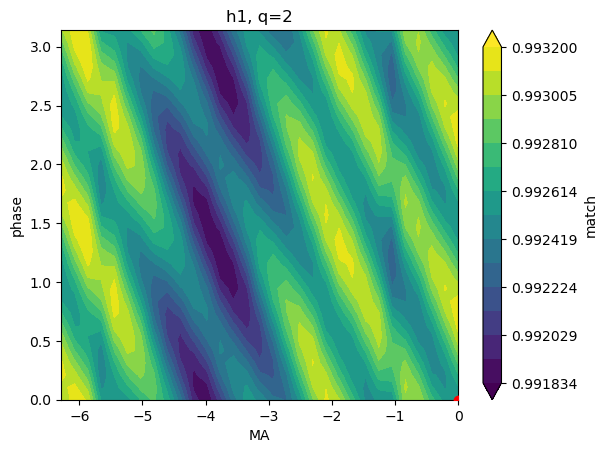

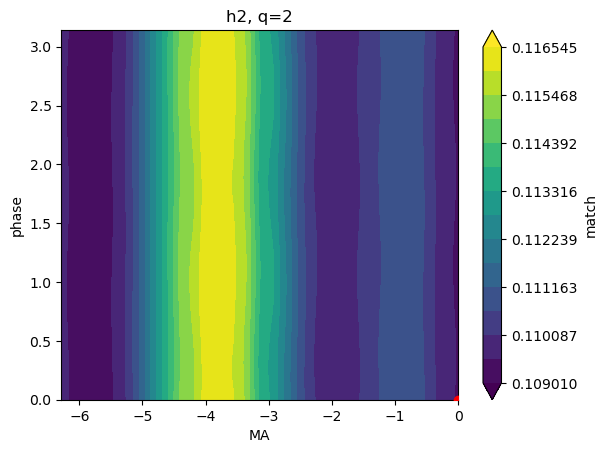

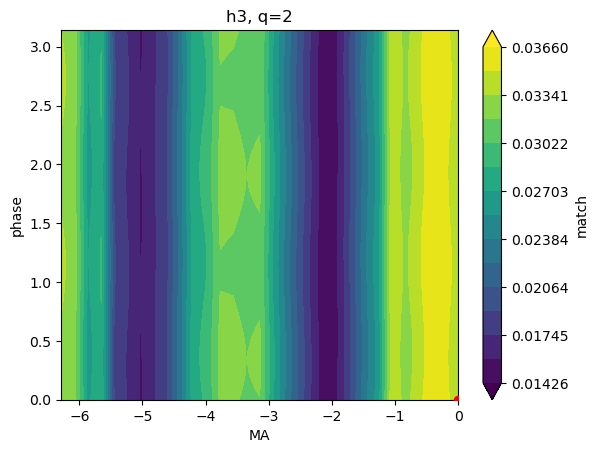

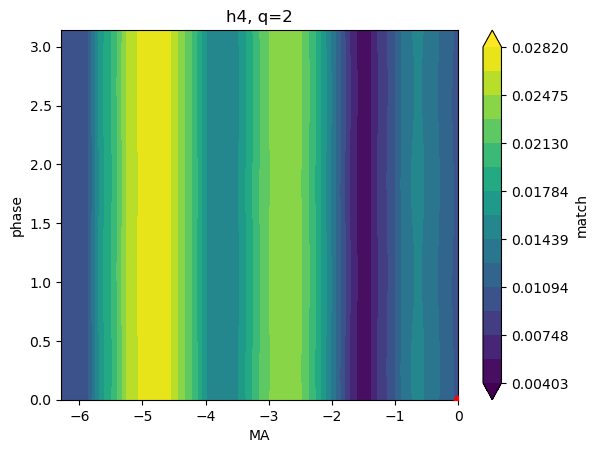

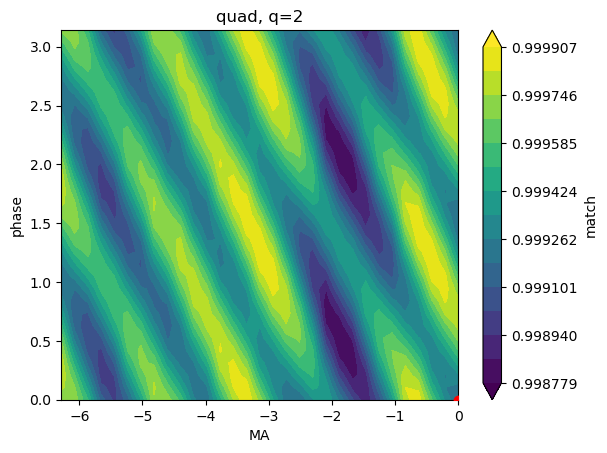

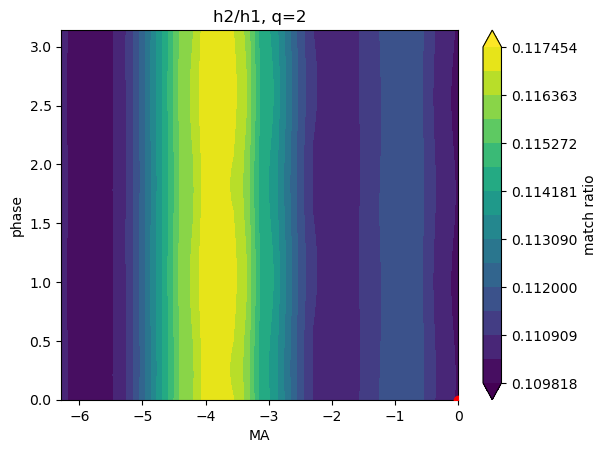

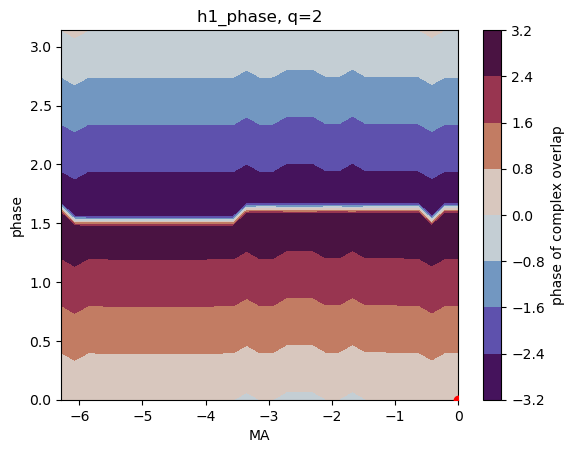

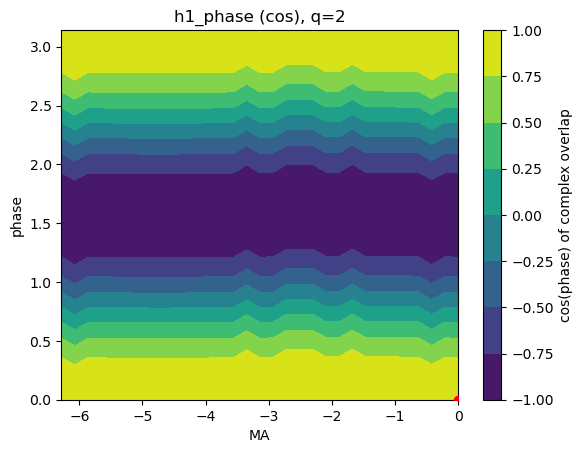

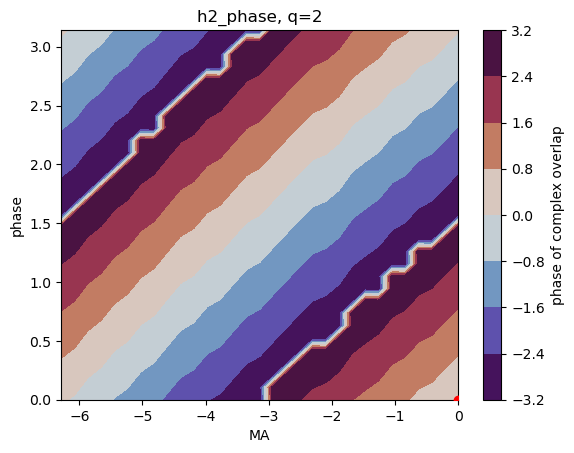

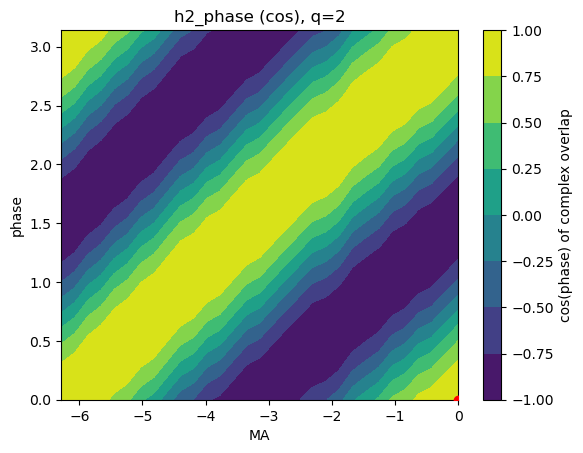

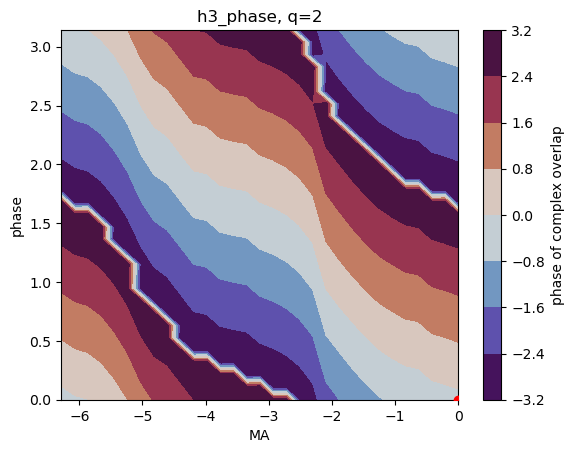

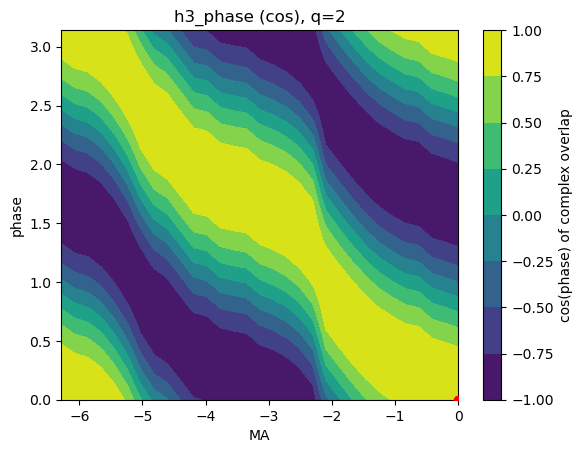

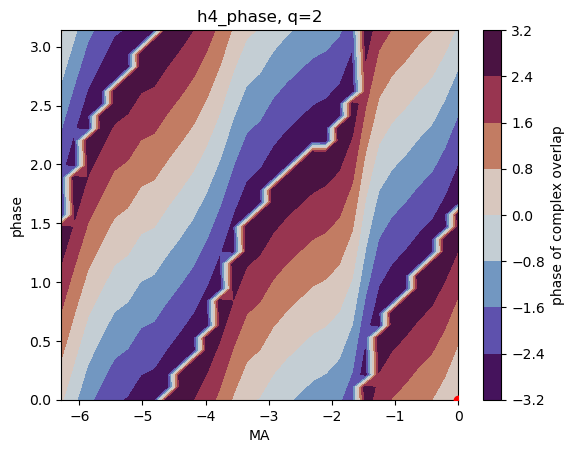

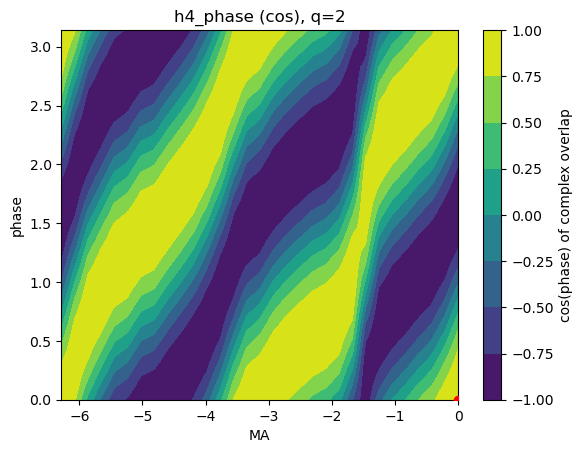

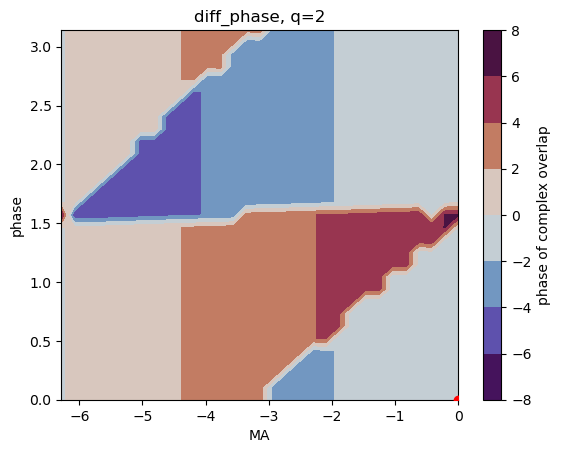

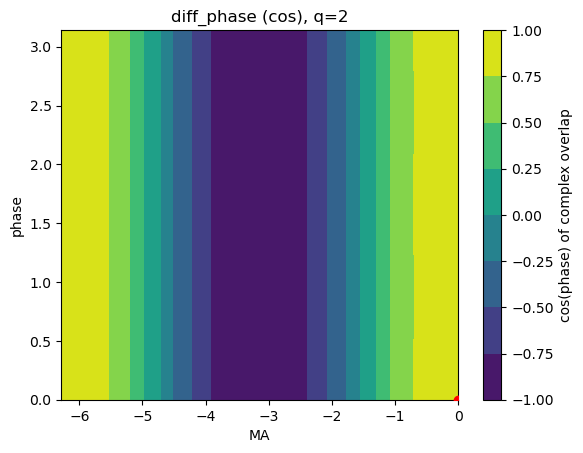

In [7]:
dataslot_0 = load_dataslot(0)
phase_MA_plot(phase_vals_0, MA_vals_0, 4, [0.1, 24, 2], dataslot_0)

# e=0.15, chirp=23.80

In [13]:
phase_vals_1 = np.linspace(0, np.pi, 31)
MA_vals_1 = np.linspace(-2*np.pi, 0, 31)
# start = time.time()
# dataslot_1 = phase_MA_match(phase_vals_1, MA_vals_1, 4, [0.1, 24, 2], 10, data_params=[0.15, 23.8, 2])
# end = time.time()
# print(f'\nTime taken: {end-start} seconds')
# save_dataslot(dataslot_1, 1)

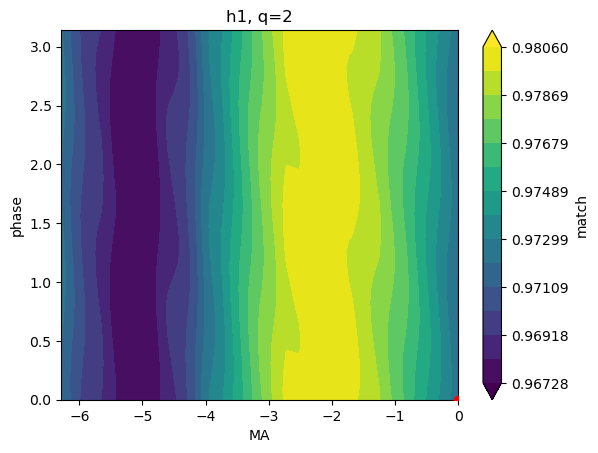

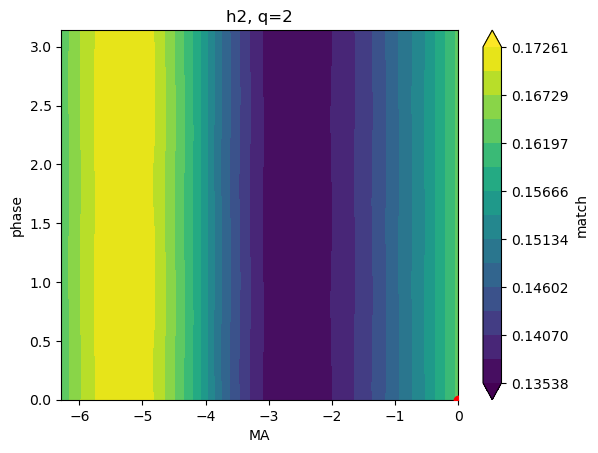

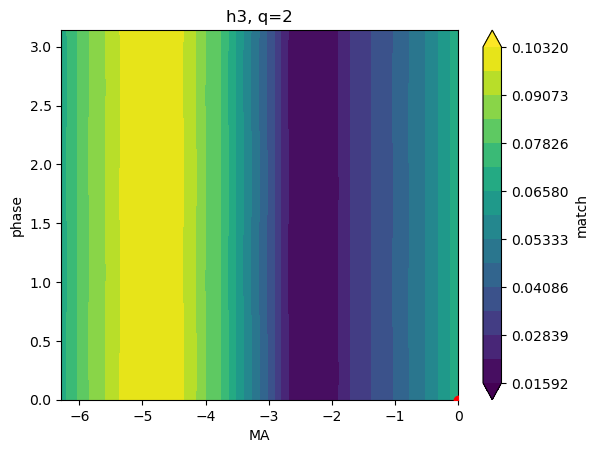

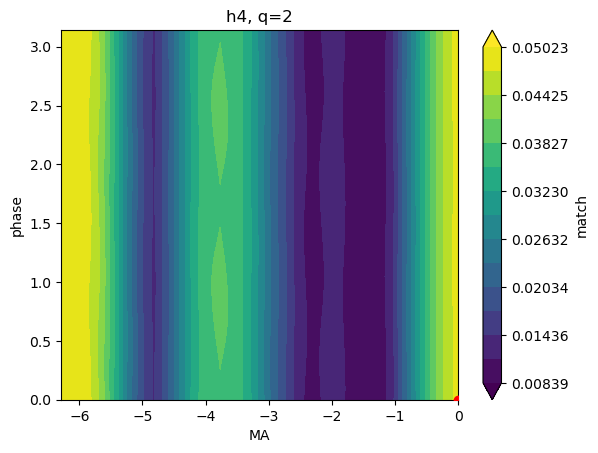

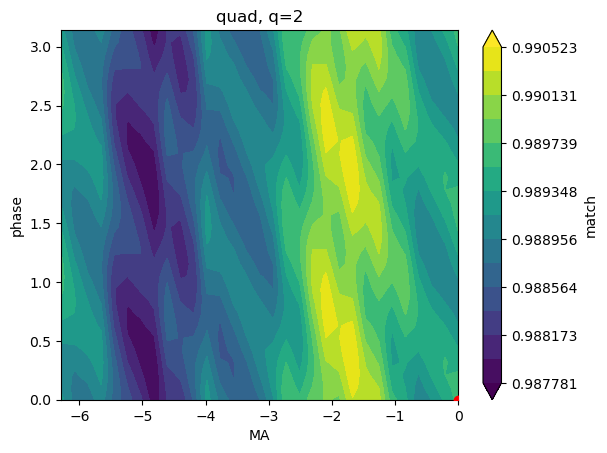

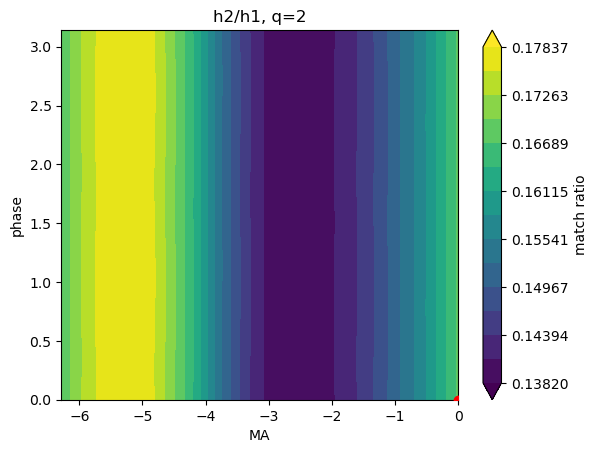

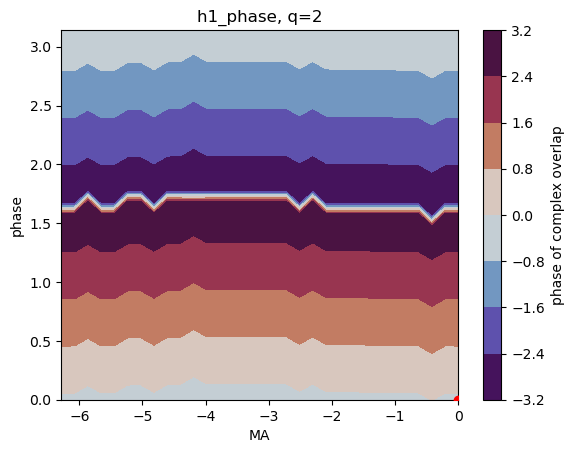

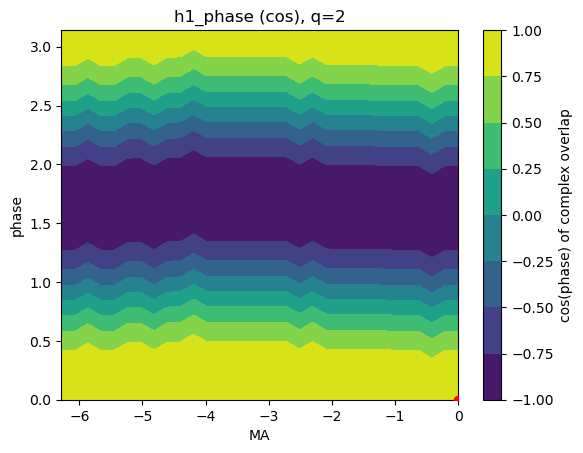

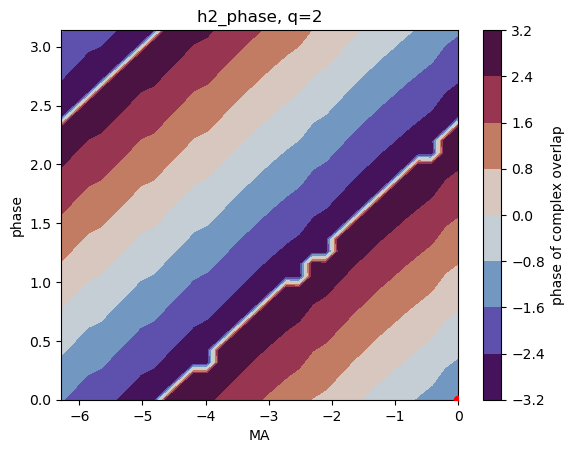

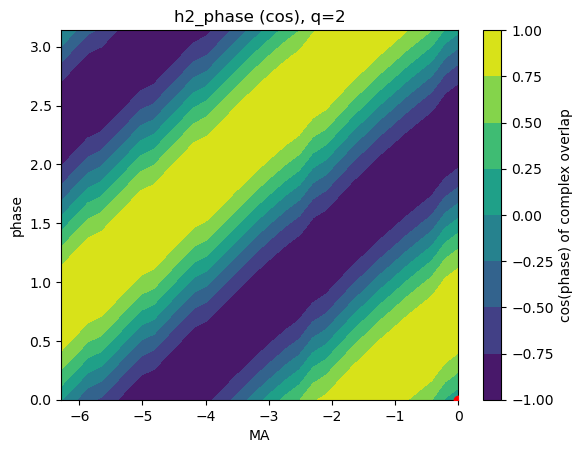

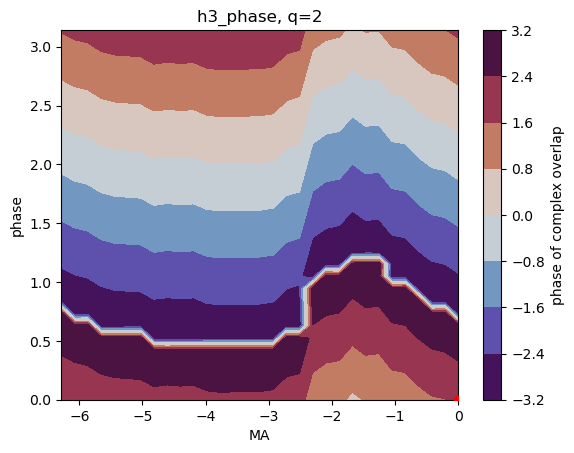

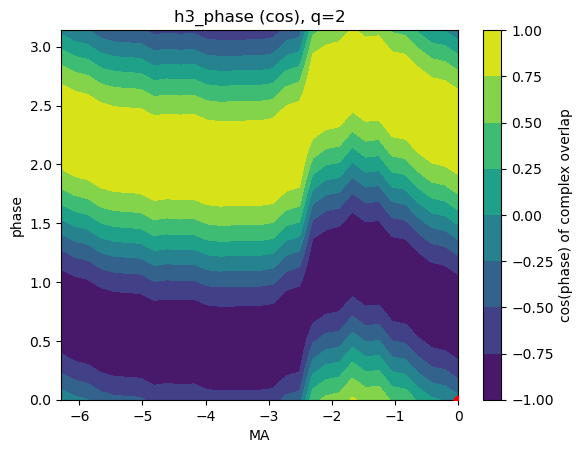

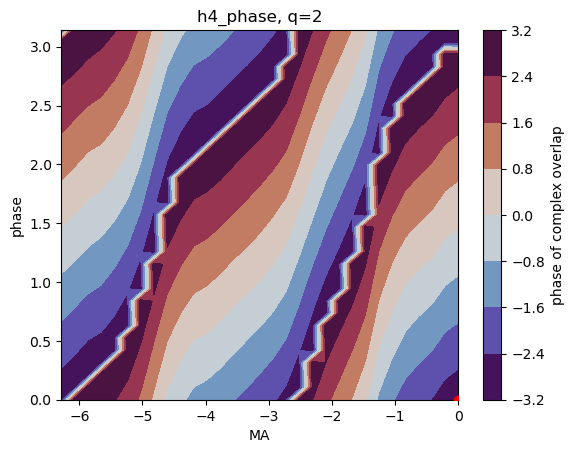

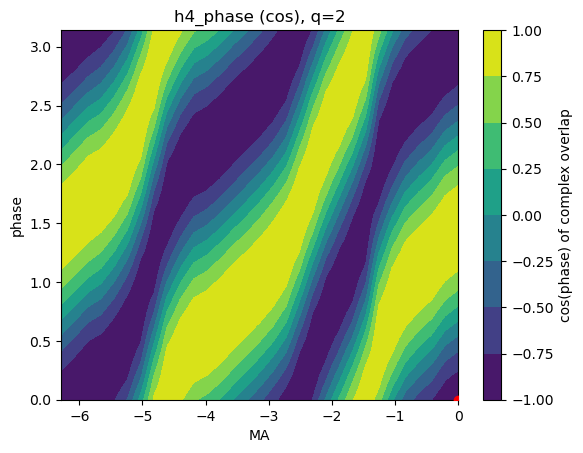

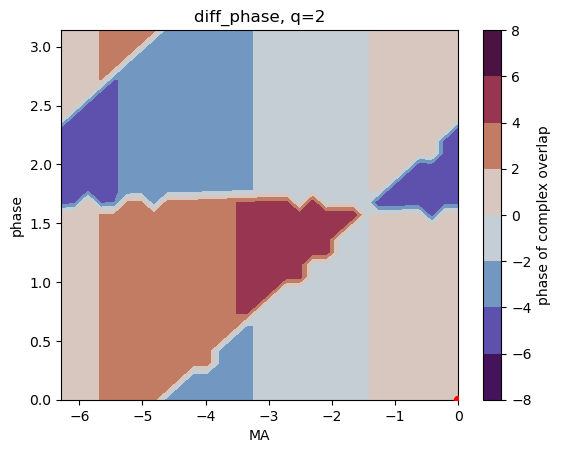

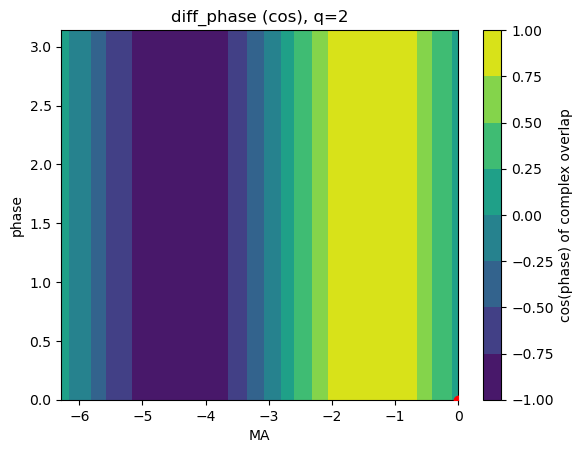

In [12]:
dataslot_1 = load_dataslot(1)
phase_MA_plot(phase_vals_1, MA_vals_1, 4, [0.1, 24, 2], dataslot_1)